In [1]:
%env TOKENIZERS_PARALLELISM=false
%env WANDB_DISABLED=true
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AdamW, 
    AutoConfig, 
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification
)

from datasets import Dataset

import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

env: TOKENIZERS_PARALLELISM=false
env: WANDB_DISABLED=true


In [2]:
class args:
    model = 'ProsusAI/finbert'

In [3]:
df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', names = ['labels','messages'],encoding='ISO-8859-1')

In [4]:
df = df[['messages', 'labels']]
df.head()

,messages,labels
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [5]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df['labels'])
df['labels'].value_counts()

labels
1    2879
2    1363
0     604
Name: count, dtype: int64

Now let's split the given data into train, test and validation

We will be using the train data to train the mode, the validation data to determiine the performance of the model and the test data to check how the model performs on unseen data

We will stratify on the `labels` so that the data remains balanced for train, test and validation data

In [6]:
X, y = df['messages'].values, df['labels'].values

# train : test = 0.9 : 0.1
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, stratify=y)

# train : valid = 0.8 : 0.2
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.2, stratify=ytrain)

# train : valid : test = 0.72 : 0.18 : 0.10 (stratified on 'labels')

# Dataset

In [7]:
train_dataset_raw = Dataset.from_dict({'text':xtrain, 'labels':ytrain})
valid_dataset_raw = Dataset.from_dict({'text':xvalid, 'labels':yvalid})

In [8]:
def tokenize_fn(examples):
    return tokenizer(examples['text'], truncation=True)

In [9]:
tokenizer = AutoTokenizer.from_pretrained(args.model)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
train_dataset_raw

Dataset({
    features: ['text', 'labels'],
    num_rows: 3488
})

In [11]:
train_dataset = train_dataset_raw.map(tokenize_fn, batched=True)
valid_dataset = valid_dataset_raw.map(tokenize_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/3488 [00:00<?, ? examples/s]

Map:   0%|          | 0/873 [00:00<?, ? examples/s]

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(args.model)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [13]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, preds)}

In [14]:
train_args = TrainingArguments(
    './Finbert Trained/',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=2*16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,    
    do_eval=True,
    do_train=True,
    do_predict=True,
    eval_strategy='epoch',
    save_strategy="no",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.346189,0.862543
2,No log,0.321907,0.877434
3,0.570700,0.421680,0.875143
4,0.570700,0.476407,0.877434
5,0.065800,0.490418,0.879725


TrainOutput(global_step=1090, training_loss=0.2942051292559422, metrics={'train_runtime': 5541.3955, 'train_samples_per_second': 3.147, 'train_steps_per_second': 0.197, 'total_flos': 531291768747264.0, 'train_loss': 0.2942051292559422, 'epoch': 5.0})

In [17]:
trainer.save_model('finbert_finetuned.bin')

In [18]:
pred_dataset_raw = Dataset.from_dict({'text': xtest})
pred_dataset_raw

Dataset({
    features: ['text'],
    num_rows: 485
})

In [19]:
pred_dataset = pred_dataset_raw.map(tokenize_fn, batched=False)

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

In [20]:
len(pred_dataset[0]['input_ids'])

25

In [21]:
output = trainer.predict(
    test_dataset=pred_dataset,
)

In [22]:
le.inverse_transform([np.argmax(x) for x in output.predictions])

array(['neutral', 'positive', 'positive', 'neutral', 'positive',
       'negative', 'neutral', 'neutral', 'neutral', 'positive', 'neutral',
       'negative', 'neutral', 'positive', 'positive', 'neutral',
       'negative', 'positive', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral',
       'neutral', 'positive', 'neutral', 'neutral', 'positive', 'neutral',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'positive', 'neutral', 'positive', 'negative', 'positive',
       'neutral', 'positive', 'neutral', 'positive', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral',
       'neutral', 'positive', 'positive', 'neutral', 'neutral',
       'positive', 'positive', 'positive', 'neutral', 'neutral',
       'neutral', 'negative', 'positive', 'positive', 'neutral',
       'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'neutral',
       'negative', 'n

In [23]:
preds = [np.argmax(x) for x in output.predictions]

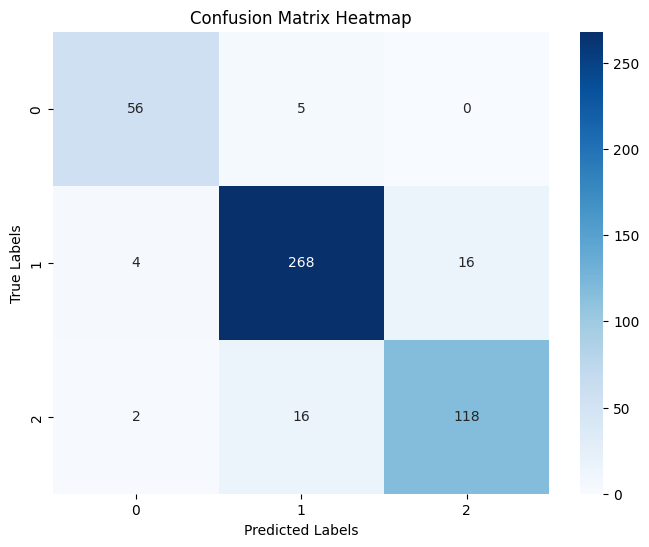

In [24]:

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(ytest, preds)

# Define class labels
labels = [0, 1, 2]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Display the plot
plt.show()

In [25]:
accuracy_score(ytest, preds)

0.911340206185567